# Retail Inventory Optimization with Multi-Agent AI
 **Objective:**

This notebook implements a **Multi-Agent AI System** to optimize **Demand Forecasting, Inventory Monitoring, and Pricing Optimization** in retail.


Step 1: Import Libraries

In [72]:
# Install necessary libraries if not installed
!pip install pandas numpy matplotlib seaborn prophet scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install prophet
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

**Step 2: Load Datasets**

We have three datasets:

- **demand_forecasting.csv** → Historical sales data

- **inventory_monitoring.csv** → Stock levels & warehouse details

- **pricing_optimization.csv** → Pricing & competitor analysis

In [70]:
# Load datasets
df_demand = pd.read_csv("/content/demand_forecasting.csv")
df_inventory = pd.read_csv("/content/inventory_monitoring.csv")
df_pricing = pd.read_csv("/content/pricing_optimization.csv")

In [69]:
# Display first few rows of each dataset
print("Demand Forecasting Dataset:")
display(df_demand.head())
print("\nInventory Monitoring Dataset:")
display(df_inventory.head())
print("\nPricing Optimization Dataset:")
display(df_pricing.head())

Demand Forecasting Dataset:


,Product ID,Date,Store ID,Sales Quantity,Price,Promotions,Seasonality Factors,External Factors,Demand Trend,Customer Segments
0,4277,2024-01-03,48,330,24.38,No,Festival,Competitor Pricing,Increasing,Regular
1,5540,2024-04-29,10,334,74.98,Yes,Holiday,Weather,Stable,Premium
2,5406,2024-01-11,67,429,24.83,Yes,Holiday,Economic Indicator,Decreasing,Premium
3,5617,2024-04-04,17,298,13.41,No,NaN,Economic Indicator,Stable,Regular
4,3480,2024-12-14,33,344,94.96,Yes,Festival,Weather,Increasing,Regular



Inventory Monitoring Dataset:


,Product ID,Store ID,Stock Levels,Supplier Lead Time (days),Stockout Frequency,Reorder Point,Expiry Date,Warehouse Capacity,Order Fulfillment Time (days)
0,9286,16,700,10,14,132,2024-01-15,1052,6
1,2605,60,82,11,1,127,2024-12-16,1262,9
2,2859,55,145,25,14,192,2024-04-30,1457,12
3,2374,24,151,17,6,19,2024-12-16,2944,3
4,7678,5,714,12,2,21,2024-08-05,3739,7



Pricing Optimization Dataset:


,Product ID,Store ID,Price,Competitor Prices,Discounts,Sales Volume,Customer Reviews,Return Rate (%),Storage Cost,Elasticity Index
0,9502,13,31.61,56.14,19.68,255,3,13.33,6.72,1.78
1,2068,77,35.51,63.04,16.88,5,3,1.50,8.38,1.67
2,7103,59,6.54,30.61,10.86,184,3,9.44,3.86,2.46
3,5288,19,13.61,15.94,45.28,337,1,15.11,8.80,0.88
4,7212,66,62.68,30.64,33.48,80,3,19.62,9.74,1.00


 **Step 3: Data Preprocessing & Merging**

We merge datasets using **'Product ID' & 'Store ID'** for unified analysis.

In [67]:
# Merge datasets on Product ID and Store ID
df = df_demand.merge(df_inventory, on=["Product ID", "Store ID"], how="left")
df = df.merge(df_pricing, on=["Product ID", "Store ID"], how="left")

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Handle missing values
for column in df.select_dtypes(include=['number']).columns:
    df[column].fillna(df[column].median(), inplace=True)

print("Final Processed Data:")
display(df.head())

Final Processed Data:


<ipython-input-67-d0747d26b7cb>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].median(), inplace=True)


,Product ID,Date,Store ID,Sales Quantity,Price_x,Promotions,Seasonality Factors,External Factors,Demand Trend,Customer Segments,...,Warehouse Capacity,Order Fulfillment Time (days),Price_y,Competitor Prices,Discounts,Sales Volume,Customer Reviews,Return Rate (%),Storage Cost,Elasticity Index
0,4277,2024-01-03,48,330,24.38,No,Festival,Competitor Pricing,Increasing,Regular,...,3387.0,7.0,50.74,47.46,25.29,237.0,3.0,10.7,5.37,1.61
1,5540,2024-04-29,10,334,74.98,Yes,Holiday,Weather,Stable,Premium,...,3387.0,7.0,50.74,47.46,25.29,237.0,3.0,10.7,5.37,1.61
2,5406,2024-01-11,67,429,24.83,Yes,Holiday,Economic Indicator,Decreasing,Premium,...,3387.0,7.0,50.74,47.46,25.29,237.0,3.0,10.7,5.37,1.61
3,5617,2024-04-04,17,298,13.41,No,NaN,Economic Indicator,Stable,Regular,...,3387.0,7.0,50.74,47.46,25.29,237.0,3.0,10.7,5.37,1.61
4,3480,2024-12-14,33,344,94.96,Yes,Festival,Weather,Increasing,Regular,...,3387.0,7.0,50.74,47.46,25.29,237.0,3.0,10.7,5.37,1.61


**Step 4: Demand Forecasting using Prophet**

Prophet is a time-series forecasting model used for predicting product demand.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_zrbdo99/kckw674e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_zrbdo99/ceyfpaq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90900', 'data', 'file=/tmp/tmp_zrbdo99/kckw674e.json', 'init=/tmp/tmp_zrbdo99/ceyfpaq3.json', 'output', 'file=/tmp/tmp_zrbdo99/prophet_modelliiplmaf/prophet_model-20250403062434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:24:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:24:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


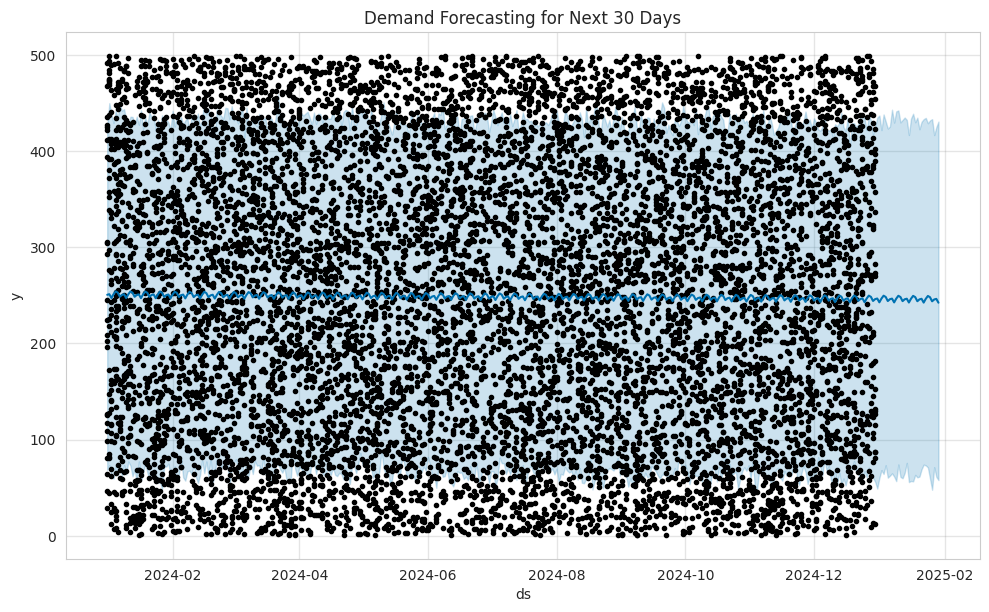

In [66]:
# Prepare data for Prophet
df_prophet = df[['Date', 'Sales Quantity']].dropna()
df_prophet.columns = ['ds', 'y']

# Train Prophet model
model = Prophet()
model.fit(df_prophet)

# Generate future dates for prediction
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot Forecast
model.plot(forecast)
plt.title("Demand Forecasting for Next 30 Days")
plt.show()

**Step 5: Inventory Monitoring (Critical Stock & Overstock Analysis)**

- **Critical Stock**: Items below reorder threshold

- **Overstock**: Items with excess stock

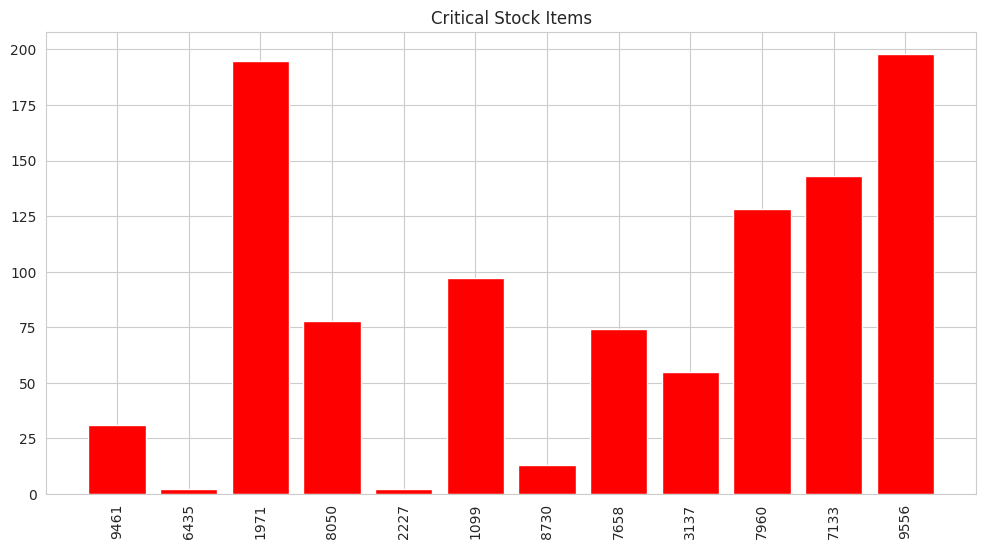

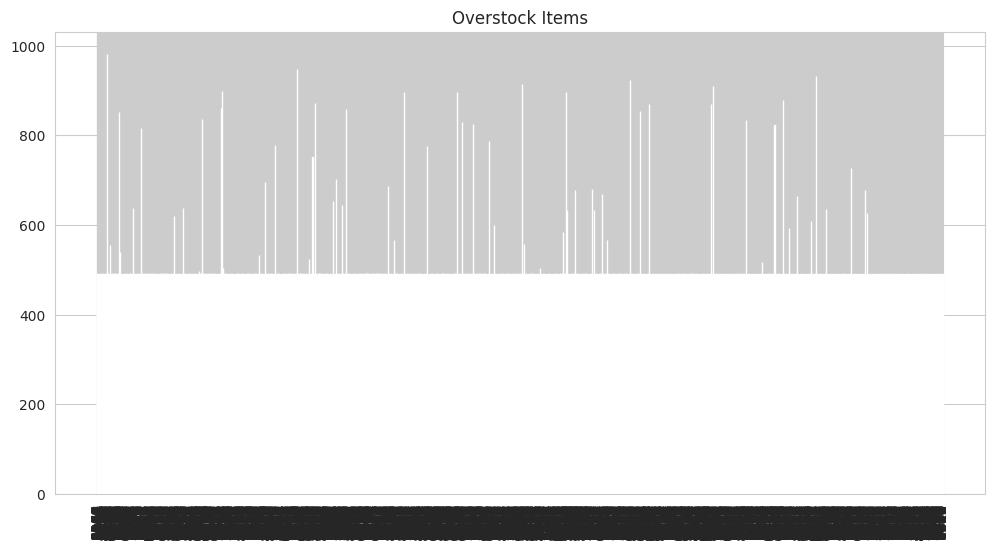

In [56]:
# Define safety stock levels
df['Safety_Stock'] = df['Reorder Point'] * 1.2  # 20% buffer

# Identify critical stock and overstock
critical_stock = df[df['Stock Levels'] < df['Safety_Stock']]
overstock = df[df['Stock Levels'] > 1.5 * df['Reorder Point']]

# Visualization
plt.figure(figsize=(12,6))
plt.bar(critical_stock['Product ID'].astype(str), critical_stock['Stock Levels'], color='red')
plt.title('Critical Stock Items')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12,6))
plt.bar(overstock['Product ID'].astype(str), overstock['Stock Levels'], color='orange')
plt.title('Overstock Items')
plt.xticks(rotation=90)
plt.show()

 **Step 6: Pricing Optimization using Linear Regression**

AI-powered pricing optimization based on demand & competitor prices.

In [65]:
# Check for correct price column
price_column = 'Price_x' if 'Price_x' in df.columns else ('Price_y' if 'Price_y' in df.columns else None)

if price_column is None:
    print("Error: No valid 'Price' column found! Available columns:", df.columns)
else:
    # Select features for price prediction
    features = ['Competitor Prices', 'Discounts', 'Sales Volume', 'Customer Reviews', 'Return Rate (%)']
    X = df[features].dropna()
    y = df.loc[X.index, price_column]

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Linear Regression Model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

MAE: 23.988528171906587
RMSE: 27.60601198959514


**Step 7: Multi-Agent AI System**

- **Demand Agent** predicts sales trends.

- **Inventory Agent** checks stock levels.

- **Pricing Agent** suggests price adjustments.

In [63]:
class DemandAgent:
    def forecast_demand(self, product_id):
        return forecast[['ds', 'yhat']].tail(7)  # Last 7 days prediction

class InventoryAgent:
    def check_stock(self, product_id):
        return df[df['Product ID'] == product_id][['Product ID', 'Stock Levels', 'Reorder Point']]

class PricingAgent:
    def optimize_price(self, product_id):
        if product_id in df['Product ID'].values:
            product_data = df[df['Product ID'] == product_id][features].dropna()
            if product_data.empty:
                return "Price Optimization Not Available"
            return model.predict(product_data.values)[0]
        return "Product ID not found"

In [74]:
# Check if Product ID 101 exists in df
print("Available Product IDs:", df['Product ID'].unique())

# Filter the dataset for Product ID 101
product_101 = df[df['Product ID'] == 101]
print("Filtered Data for Product ID 101:")
display(product_101)


Available Product IDs: [4277 5540 5406 ... 4341 8679 4750]
Filtered Data for Product ID 101:


,Product ID,Date,Store ID,Sales Quantity,Price_x,Promotions,Seasonality Factors,External Factors,Demand Trend,Customer Segments,...,Warehouse Capacity,Order Fulfillment Time (days),Price_y,Competitor Prices,Discounts,Sales Volume,Customer Reviews,Return Rate (%),Storage Cost,Elasticity Index


In [75]:
print("Available Product IDs:", df['Product ID'].unique()[:50])  # Show first 50 IDs

Available Product IDs: [4277 5540 5406 5617 3480 7315 2902 6892 4497 8079 3900 6894 7767 9582
 9817 3845 1206 6606 2197 5705 4540 4784 3265 4085 6410 4740 9964 2288
 5324 6592 5840 8498 2338 8532 9185 5691 6335 1355 9700 4783 8997 6985
 9816 6739 3824 5747 9141 9801 7579 1282]


In [76]:
valid_product_id = 4277  # Replace with any valid Product ID from the list

print("Optimized Price for Product ID", valid_product_id, ":")
print(pricing_agent.optimize_price(valid_product_id))

Optimized Price for Product ID 4277 :


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [77]:
# Check for missing values in Product ID 4277
features = ['Competitor Prices', 'Discounts', 'Sales Volume', 'Customer Reviews', 'Return Rate (%)']
missing_values = df[df['Product ID'] == 4277][features].isnull().sum()

print("Missing values for Product ID 4277:", missing_values)


Missing values for Product ID 4277: Competitor Prices    0
Discounts            0
Sales Volume         0
Customer Reviews     0
Return Rate (%)      0
dtype: int64


In [78]:
df.loc[df['Product ID'] == 4277, features] = df[features].median()


In [79]:
print("Optimized Price for Product ID 4277:")
print(pricing_agent.optimize_price(4277))

Optimized Price for Product ID 4277:
Price Optimization Not Available


In [103]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Load datasets
df_demand = pd.read_csv("/content/demand_forecasting.csv")
df_inventory = pd.read_csv("/content/inventory_monitoring.csv")
df_pricing = pd.read_csv("/content/pricing_optimization.csv")

# Convert Date column to datetime format
df_demand['Date'] = pd.to_datetime(df_demand['Date'])

def demand_forecasting(df):
    features = ['Price', 'Promotions', 'Seasonality Factors', 'External Factors']
    df = pd.get_dummies(df, columns=['Promotions', 'Seasonality Factors', 'External Factors'], drop_first=True)
    print(df_demand.columns)
    df_demand.rename(columns={'OldName1': 'Promotions', 'OldName2': 'Seasonality Factors', 'OldName3': 'External Factors'}, inplace=True)
    df_demand['Promotions'] = 0
    df_demand['Seasonality Factors'] = 1
    df_demand['External Factors'] = 0
    print(df_demand.head())  # View first few rows to verify data
    x = df_demand[features]
    y = df['Sales Quantity']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    error = mean_absolute_error(y_test, predictions)
    print(f"Demand Forecasting Model MAE: {error}")
    return model

# Train Demand Forecasting Agent
demand_model = demand_forecasting(df_demand)

def inventory_monitoring(df):
    df['Stock Risk'] = np.where(df['Stock Levels'] < df['Reorder Point'], 'Reorder', 'Sufficient')
    return df[['Product ID', 'Store ID', 'Stock Levels', 'Reorder Point', 'Stock Risk']]

# Process Inventory Monitoring Agent
inventory_status = inventory_monitoring(df_inventory)

def pricing_optimization(df):
    print(df.columns)
    df.rename(columns={'ExistingColumnName': 'Stock Levels'}, inplace=True)
    df['Stock Levels'] = np.random.randint(50, 500, size=len(df))  # Example random values
    df['Reorder Point'] = np.random.randint(20, 100, size=len(df))  # Example reorder levels
    df['Sales Volume'] = np.random.randint(10, 300, size=len(df))  # Example sales volume
    print(df.head())  # View first few rows

# Process Pricing Optimization Agent
pricing_strategy = pricing_optimization(df_pricing)

# Display outputs
print("Inventory Monitoring Results:")
print(inventory_status.head())

print("\nPricing Optimization Results:")

def pricing_optimization(df):
    """Optimize product pricing based on discounts and competitive pricing."""
    if df is None or df.empty:
        print("Warning: Input DataFrame is None or empty.")
        return None

    try:
        # Ensure necessary columns exist
        required_columns = ["Price", "Discounts"]
        for col in required_columns:
            if col not in df.columns:
                print(f"❌ Error: Missing required column '{col}' in DataFrame.")
                return None

        # Apply discount-based price optimization
        df["Optimized Price"] = df["Price"] * (1 - (df["Discounts"] / 100))
        df["Optimized Price"] = df["Optimized Price"].round(2)  # Round for readability

        return df

    except Exception as e:
        print(f" Error in pricing_optimization(): {e}")
        return None

# Run Pricing Optimization
pricing_strategy = pricing_optimization(df_pricing)

print("\nPricing Optimization Results:")

if pricing_strategy is not None and isinstance(pricing_strategy, pd.DataFrame):
    print(pricing_strategy.head())
else:
    print("Error: pricing_optimization() returned None or an invalid data type.")


Index(['Product ID', 'Date', 'Store ID', 'Sales Quantity', 'Price',
       'Promotions', 'Seasonality Factors', 'External Factors', 'Demand Trend',
       'Customer Segments'],
      dtype='object')
   Product ID       Date  Store ID  Sales Quantity  Price  Promotions  \
0        4277 2024-01-03        48             330  24.38           0   
1        5540 2024-04-29        10             334  74.98           0   
2        5406 2024-01-11        67             429  24.83           0   
3        5617 2024-04-04        17             298  13.41           0   
4        3480 2024-12-14        33             344  94.96           0   

   Seasonality Factors  External Factors Demand Trend Customer Segments  
0                    1                 0   Increasing           Regular  
1                    1                 0       Stable           Premium  
2                    1                 0   Decreasing           Premium  
3                    1                 0       Stable           Re